- This note explores localization using RSSI and CIR, to verify if CIR outperfoms on the other.

In [ ]:
import sys
sys.path.append('../../Polished_code')

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tools import *

In [78]:
cirs = np.load('cirs_noised_ld.npy')
cirs_obs = np.load('cirs_observation_ld_exact.npy')
triplets = np.load('triplets_ld.npy')
anchor_idx = np.load('anchor_idx.npy')
pos_idx = np.load('pos_idx.npy')
neg_idx = np.load('neg_idx.npy')

In [189]:
cirs_all = np.concatenate([np.real(cirs_obs), np.imag(cirs_obs)], axis=1)

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.ensemble import AdaBoostRegressor as ABR
from sklearn.pipeline import Pipeline
import lightgbm as lgb

In [6]:
location = 'london_square_20'
base = f'../../Simulation/dataset/data_with_building/{location}_cell.mat'
# base = f'../Simulation/dataset/data_with_building/{location}_cell.mat'
meta_data_ld, cir_profile_ld, dist_ld, TX_ld, RX_ld = read_mat(base, location)

In [7]:
max_len = 5
ext_ld = Extractor(cir_profile_ld)
X_ld = ext_ld.formatting_X(max_len=max_len)

../../Polished_code\tools.py:145: ComplexWarning: Casting complex values to real discards the imaginary part
  self.mag = - math.floor(math.log(np.mean(self.delay_set), 10))
../../Polished_code\tools.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  cir_t.append(np.array(cir_shaped, dtype='float').flatten())


In [8]:
t_max = np.real(max(ext_ld.delay_set))
fc = 2e6 # sampling rate
W = 1e6  # cut-off freq
t = np.linspace(0,t_max, int(fc * t_max)+1)

In [9]:
def sinc_filter(cirs, t, snr=20):
    '''Adding sinc filtering to cirs
    return noised and pure CIR
    '''
    T, S = cirs.shape
    cir_full_noise = []
    cir_pure = []
    # snr = 20

    x_pre = []
    for j in range(T):
        cir_t = [] # channel impulse response for a transmitter
        for i in range(S):
            status, _ = cirs[j, i].shape
            if status == 1:
                x_n = np.zeros_like(t)
                y = x_n
                # nan_idx.append([j, i]) # index of no-signal tx
            else:
                tau, amp = cirs[j, i].copy()
                tau_noise = np.random.normal(np.real(tau), .05 * np.real(tau))
                ans = np.repeat(t[:, None], len(tau), axis=1) - tau_noise
                y = np.sinc(W * ans) @ amp
                # c_tmp_noise = noise_gen(y, snr)
                n = len(y)
                noise = np.random.randn(n, 2).view(np.complex128)
                signal_power = np.sum(y * y) / n
                signal_db = 10 * np.log10(signal_power)
                noise_power = np.sum(noise * noise) / n
                noise_var = signal_power / (10 ** (snr/10))
                # noise_var = 10 ** ((signal_db - snr) / 10)
                # # print(noise_var)
                noise_gaussian = np.sqrt(noise_var / noise_power) * noise
                # noise_gaussian = np.random.normal(0, np.sqrt(noise_var), n).view(np.complex128)
            x_n = y + np.squeeze(noise_gaussian)
            cir_full_noise.append(x_n)
            cir_pure.append(cirs[j, i])

    return cir_full_noise, cir_pure

In [25]:
cirs_ld_sinc, cirs_pure = sinc_filter(cir_profile_ld, t, snr=10)

c:\Users\11740\AppData\Local\Programs\Python\Python38\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\11740\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\ma\core.py:3371: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


<StemContainer object of 3 artists>

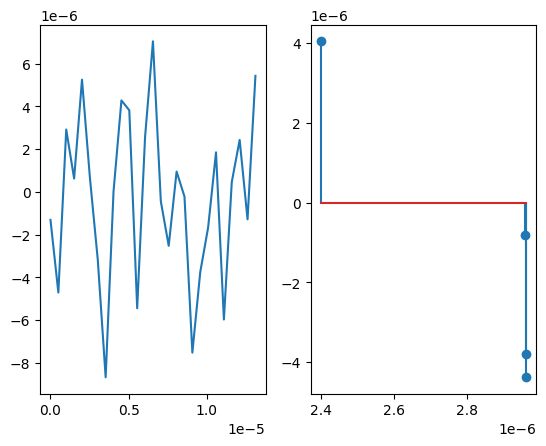

In [26]:
ind = np.random.randint(10000)
tau, amp = cirs_pure[ind]
fig, axs = plt.subplots(1, 2)
axs[0].plot(t, cirs_ld_sinc[ind])
axs[1].stem(tau, amp)

In [207]:
new_ld_sinc = np.reshape(cirs_ld_sinc, (400,-1))
cirs_pure = np.reshape(cirs_pure, (400, -1)) 

In [208]:
ld_real, ld_imag = np.real(new_ld_sinc), np.imag(new_ld_sinc)
total = np.concatenate([ld_real, ld_imag], axis=1)
# cirs_pure_all = np.concatenate([np.real(cirs_pure), np.imag(cirs_pure)], axis=1)

In [77]:
np.save('./data/total', total)

In [88]:
np.save('./data/cirs_all', cirs_all)

## CIRs feature analyzation

In [18]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

In [178]:
cirs_pure 
sig_len = len(t)

Text(0.5, 1.0, 'Covariance of CIR fingerprint')

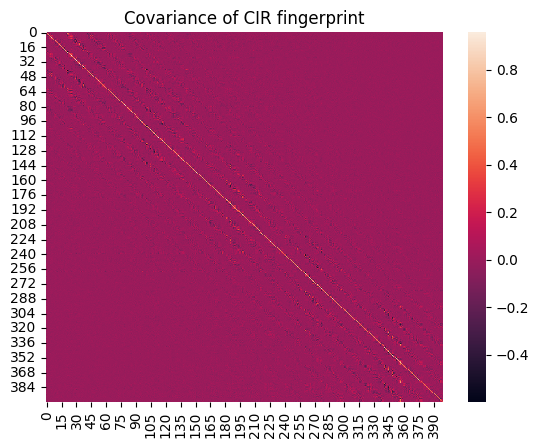

In [209]:
sns.heatmap(preprocessing.normalize(np.cov(cirs_pure_all)))
plt.title('Covariance of CIR fingerprint')

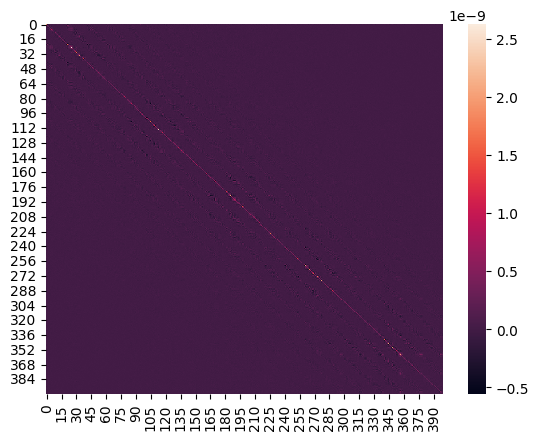

In [122]:
sns.heatmap(np.cov(total))
plt.savefig('./imgs/cov_cir.pdf')

In [16]:
x_train, x_test, y_train, y_test = train_test_split(cirs_obs, TX_ld, train_size=.75)

In [184]:
rf_grid = {
    'rf__max_depth': [ 1000, 1500, 2000]
}

lgb_grid = {
    'lgb__estimator__n_estimators': [200, 500, 2000],
    'lgb__estimator__max_depth': [500, 1000, 2500]
}

xgb_grid = {
    'xgb__estimator__n_estimators': [200, 500, 2000],
    'xgb__estimator__max_depth': [500, 1000, 2500]
}

ada_grid = {
    'ada__estimator__n_estimators': [200, 500, 1000]
}

xgb_pipe = GridSearchCV(
                Pipeline([('scale', StandardScaler()), \
                    ('xgb', MultiOutputRegressor(xgb.XGBRegressor(eta=0.1, 
                                                    subsample=1, 
                                                    colsample_bytree=1, 
                                                    reg_lambda=0))
                                                    )]),
                xgb_grid)

lgb_pipe = GridSearchCV(
                Pipeline([('scale', StandardScaler()), \
                    ('lgb', MultiOutputRegressor(lgb.LGBMRegressor(subsample=1, 
                                                                    colsample_bytree=1, 
                                                                    reg_lambda=0)))]),
                lgb_grid)

rf_pipe = GridSearchCV(
                Pipeline([('scale', StandardScaler()), ('rf', RF())]), 
                rf_grid)

ada_pipe = GridSearchCV(
                Pipeline([('scale', StandardScaler()), \
                ('ada', MultiOutputRegressor(ABR(n_estimators=100)))]), 
                ada_grid)

In [192]:
lgb_pipe = Pipeline([('lgb', MultiOutputRegressor(lgb.LGBMRegressor(subsample=1, 
                                                                    colsample_bytree=1, 
                                                                    reg_lambda=0,
                                                                    n_estimators=800,
                                                                    max_depth=50)))])

In [210]:
lgb_pipe.fit(cirs_all, TX_ld)

Pipeline(steps=[('lgb',
                 MultiOutputRegressor(estimator=LGBMRegressor(colsample_bytree=1,
                                                              max_depth=50,
                                                              n_estimators=800,
                                                              reg_lambda=0,
                                                              subsample=1)))])

In [219]:
tx_pred = lgb_pipe.predict(cirs_pure)
d = distance_tr(tx_pred, RX_ld)

In [185]:
pipes_ld = PipesFitting(cirs_all, TX_ld, RX_ld)
pipes_ld.add_pipes([lgb_pipe], ['LGBM'])
pipes_ld.fit()

In [188]:
pipes_ld.dist_all[0].var()

5793.601449834528

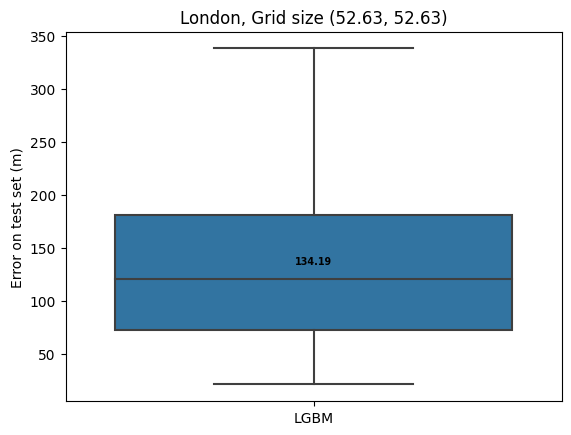

In [187]:
v_ld = VisualizeResult(pipes_ld, location='London')
v_ld.boxplot_pipes()

In [31]:
pipes = [xgb_pipe, lgb_pipe, rf_pipe, ada_pipe]
model_ls = ['XGB', 'LGBM', 'RF', 'ADA']

# pipes_ld = PipesFitting(np.real(cirs_obs), TX_ld, RX_ld)
pipes_ld = PipesFitting(total, TX_ld, RX_ld)
pipes_ld.add_pipes(pipes, model_ls)
pipes_ld.fit()

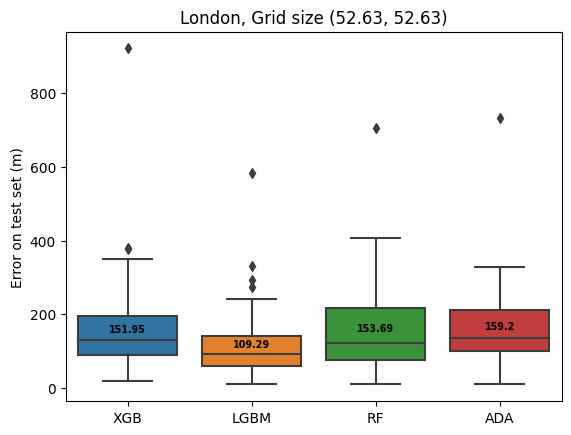

In [32]:
v_ld = VisualizeResult(pipes_ld, location='London')
v_ld.boxplot_pipes()

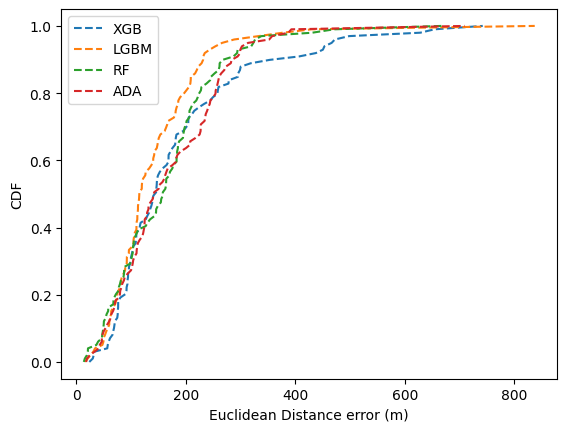

In [35]:
v_ld.cdf_plot()

## Prediction using RSSI

In [51]:
import scipy.io

In [118]:
rssi_dir = f'../../Simulation/dataset/rssi_london.mat'
rssi_ld = scipy.io.loadmat(rssi_dir)['rssi_london']

In [83]:
np.cov(rssi_ld, rssi_ld).shape

(800, 800)

In [167]:
from sklearn import preprocessing

Text(0.5, 1.0, 'Covariance of RSSI fingerprint')

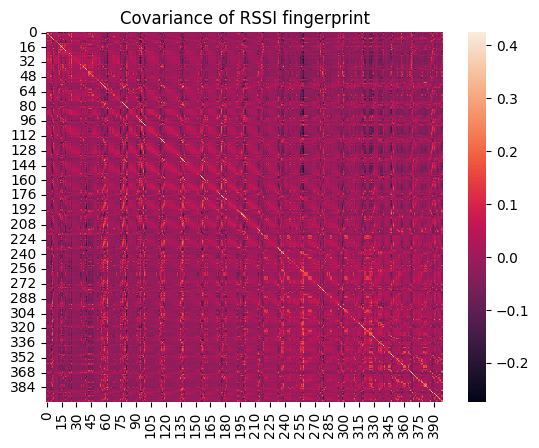

In [171]:
sns.heatmap(preprocessing.normalize(np.cov(rssi_ld)))
plt.title('Covariance of RSSI fingerprint')


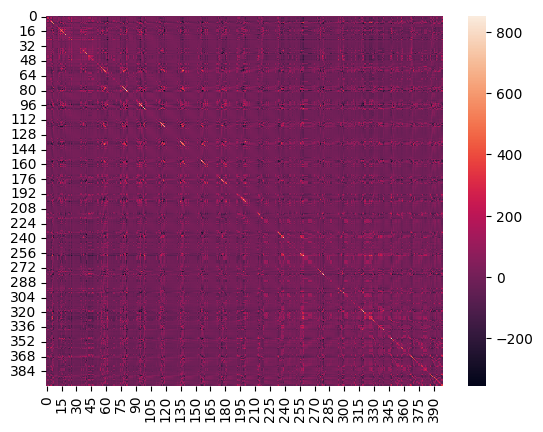

In [123]:
sns.heatmap(np.cov(rssi_ld))
# plt.title('Covariance of RSSI fingerprint')
plt.savefig('./imgs/cov_rssi.pdf')

In [109]:
dtw_mtx = np.load('data/dtw_mtx.npy')

<Axes: >

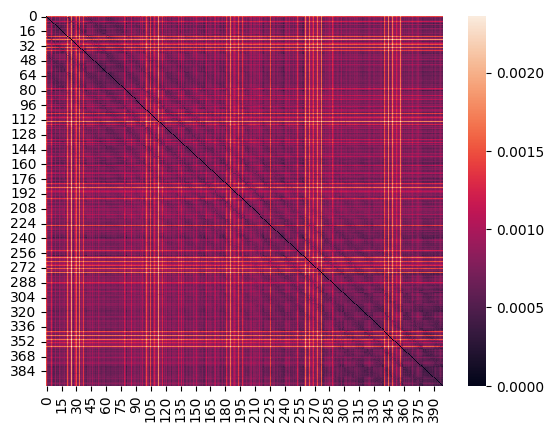

In [173]:
sns.heatmap(dtw_mtx)

<Axes: >

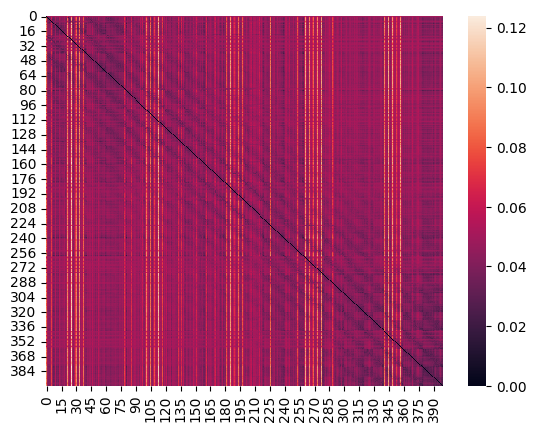

In [172]:
sns.heatmap(preprocessing.normalize(dtw_mtx))

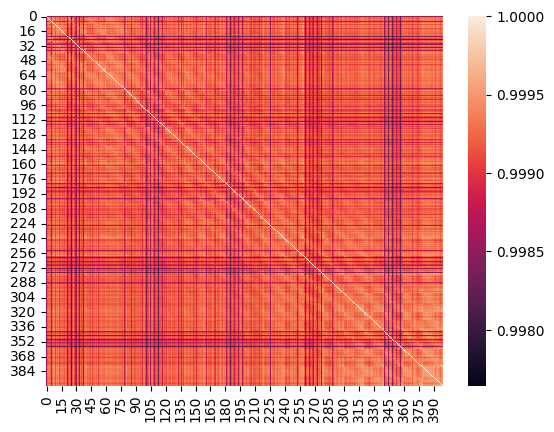

In [157]:
np.mean(dtw_mtx)
sns.heatmap(np.exp(-dtw_mtx))
plt.savefig('imgs/negexp_dtw_cir.pdf')

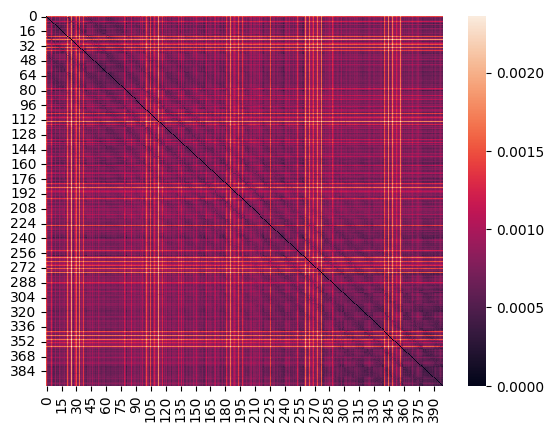

In [124]:
sns.heatmap(dtw_mtx)
plt.savefig('imgs/cov_dtw_cir.pdf')

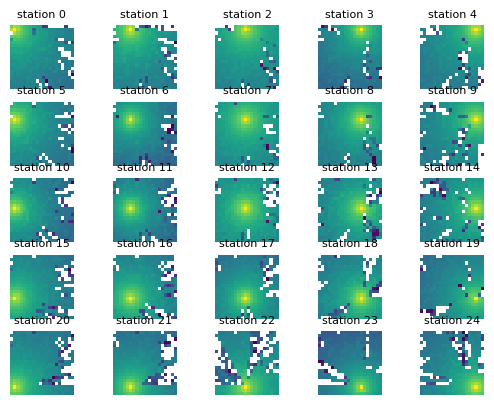

In [108]:
fig, axs = plt.subplots(5, 5)

for i in range(25):
    r, c = i // 5, i % 5
    tmp = np.reshape(rssi_ld[:, i], (20, 20))
    axs[r, c].imshow(tmp, )
    axs[r, c].axis('off')
    axs[r, c].set_title(f'station {i}',  fontsize=8)

plt.savefig('./imgs/rssi_distribution.pdf')

In [120]:
x_train, x_test, y_train, y_test = train_test_split(rssi_ld, TX_ld, train_size=.75)

In [119]:
rssi_ld = np.nan_to_num(rssi_ld, neginf=1)

In [123]:
pipes = [xgb_pipe, lgb_pipe, rf_pipe, ada_pipe]
model_ls = ['XGB', 'LGBM', 'RF', 'ADA']

pipes_ld = PipesFitting(rssi_ld, TX_ld, RX_ld)
pipes_ld.add_pipes(pipes, model_ls)
pipes_ld.fit()

In [55]:
pipes_rssi = [lgb_pipe]
model_rssi = ['LGBM']

pipes_ld_rssi = PipesFitting(rssi_ld, TX_ld, RX_ld)
pipes_ld_rssi.add_pipes(pipes_rssi, model_rssi)
pipes_ld_rssi.fit()

In [95]:
from joblib import dump
from sklearn.model_selection import cross_val_score

# dump(pipes_ld, 'model_lgbm.joblib')

In [98]:
np.save('data/TX_ld', TX_ld)
np.save('data/RX_ld', RX_ld)

In [ ]:
cross_val_score(pipes_ld.model_all[0], cirs_all, TX_ld, cv=5, scoring='neg_mean_squared_error')

In [147]:
pipes_ld.model_all[0].best_params_

{'lgb__estimator__max_depth': 500, 'lgb__estimator__n_estimators': 2000}

In [136]:
import pickle
  
# Save the trained model as a pickle string.
saved_model = pickle.dumps(pipes_ld.model_all[0])

In [138]:
import joblib

In [ ]:
model_cir = joblib.load('model_lgbm_cir.joblib')
model_rssi = joblib.load('model_lgbm_rssi.joblib')

In [166]:
model_cir.dist_all[0].var(), model_cir.dist_all[0].mean(), model_rssi.dist_all[0].var(), model_rssi.dist_all[0].mean()

(8088.276165968319, 134.735114242305, 12738.728769723964, 112.14349619316361)

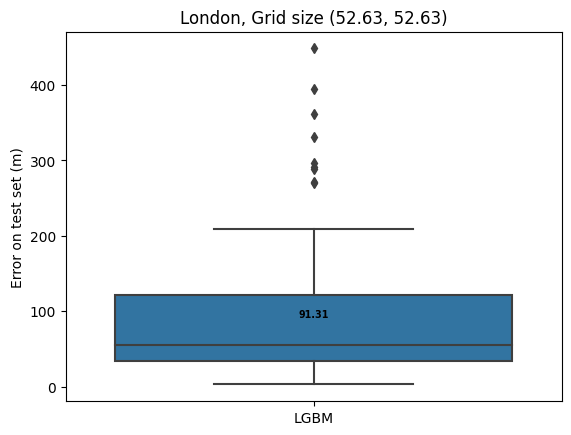

In [131]:
v_ld_rssi = VisualizeResult(pipes_ld_rssi, location='London')
v_ld_rssi.boxplot_pipes()

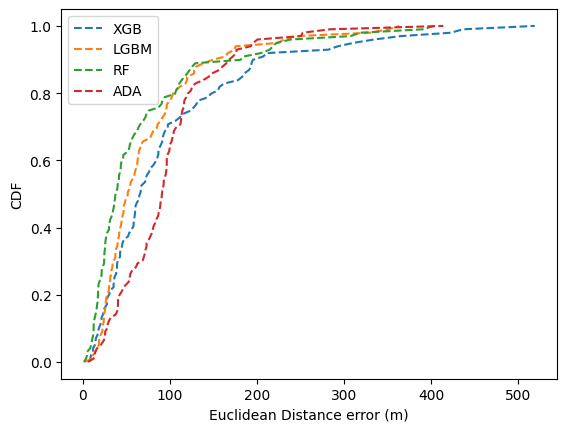

In [125]:
v_ld.cdf_plot()

Text(0.5, 0, 'distance error(m)')

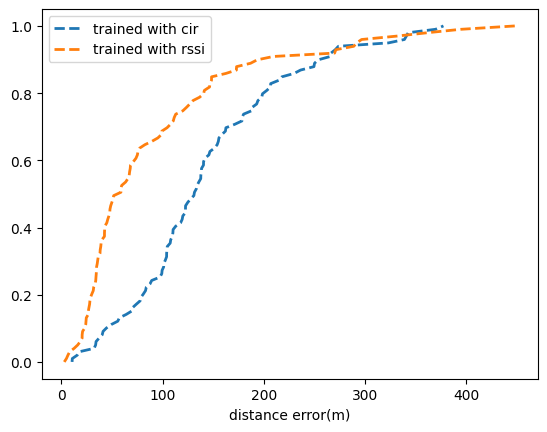

In [139]:
cdf_plot(pipes_ld.dist_all[0], label='trained with cir')
cdf_plot(pipes_ld_rssi.dist_all[0], label='trained with rssi')
plt.legend()
plt.xlabel('distance error(m)')

# 1NN

In [91]:
np.shape(total), np.shape(cirs_all)

((400, 1350), (400, 1350))

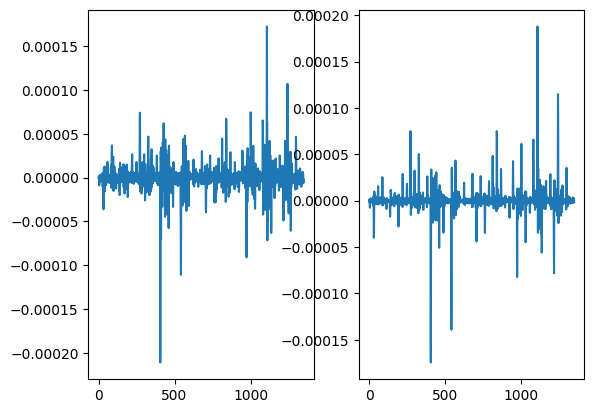

In [107]:
ind = np.random.randint(400)
tau, amp = cirs_pure[ind]
fig, axs = plt.subplots(1, 2)
axs[0].plot(total[ind])
axs[1].plot(cirs_all[ind])
axs[1].set_xtext('Pure CIR with sinc')

Text(0.5, 1.0, 'Correlation between $\\hat{X}$ and $X$')

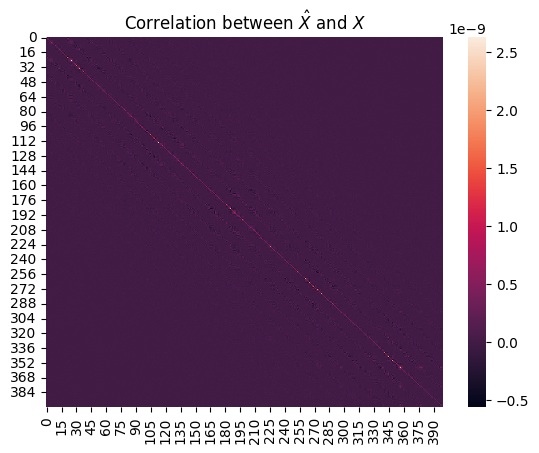

In [159]:
cov_obs = np.cov(cirs_all, total)
sns.heatmap(cov_obs[400:, 400:])
plt.title('Correlation between $\hat{X}$ and $X$')

In [128]:
from sklearn.neighbors import NearestNeighbors

In [129]:
nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(cirs_all)

In [ ]:
nn_rssi = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(rssi_ld)

In [130]:
cirs_all.shape, total[0].shape

((400, 1350), (1350,))

In [133]:
d, i = nn.kneighbors([total[100]])